## Q learning with the CartPole-v1 using Monte Carlo

For a detailed description of the cartpole env, refer to [this](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) site

In [2]:
import numpy as np 
import gym

### Configuring the display using matplotlib

In [3]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Description

#### Action space

The action is an `ndarray` with shape `(1,)` which can take values {0, 1} indicating the direction of the fixed force the cart is pushed with.

#### State Space

The observation is an `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

| Num |      Observation      |         Min         |        Max        |   |
|:---:|:---------------------:|:-------------------:|:-----------------:|---|
| 0   | Cart Position         | -4.8                | 4.8               |   |
| 1   | Cart Velocity         | -Inf                | Inf               |   |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |   |
| 3   | Pole Angular Velocity | -Inf                | Inf               |   |

#### Rewards

Since the goal is to keep the pole upright for as long as possible, a reward of `+1` for every step taken, including the termination step, is allotted. The threshold for rewards is `475` for v1.

#### Starting State

All observations are assigned a uniformly random value in (-0.05, 0.05)

#### Episode

The episode ends if any one of the following occurs:

- `Termination`: Pole Angle is greater than ±12°</li>
- `Termination`: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)</li>
- `Truncation`: Episode length is greater than 500 (200 for v0)</li>


### Discretizer

In [8]:
from sklearn.preprocessing import KBinsDiscretizer
import math
from typing import Tuple

In [9]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))

#### Define the policy
<!-- $\epsilon$ / $|A|$ + 1 - $\epsilon$ --- $max_{a}Q(s, a)$ -->

In [11]:
def policy( state : tuple , eps = 0.1):
    """
    Epsilon greedy policy
    Choose the next action as follows
    eps / |A| + (1 - eps) --> greedy best
    eps / |A|             --> others
    """
    return np.argmax(Q_table[state]) if np.random.random() <= 1 - eps else np.random.randint(len(Q_table[state]))

#### Update q-table

In [12]:
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    """Here we simply do a max on the best action possible from the next state"""
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

#### Learning rate

In [13]:
def learning_rate(n : int) -> float  :
    """Decaying learning rate"""
    return 1 / n

### The runner

In [14]:
env_rgb = lambda rendered_list: np.array(rendered_list).squeeze()

In [22]:
n_episodes = 5

def Q_learning(environment, discretizer, Q_table, n_episodes = 5):
    for e in range(n_episodes):

        # Discretize state into buckets
        current_state = discretizer(*environment.reset())
        img = plt.imshow(env_rgb(environment.render()))

        iters = 1
        done = False

        while not done:
            # Choose the current action using eps greedy policy
            action = policy(current_state) # exploit

            # Take a step in the enviroment
            obs, reward, done, _, _ = environment.step(action)
            new_state = discretizer(*obs)

            # Update the display
            plt.title(f"Episode no: {e+1} Iteration no: {iters}")       
            img.set_data(env_rgb(environment.render()))
            display.display(plt.gcf())
            display.clear_output(wait=True) 

            # Update the q-table
            lr = learning_rate(e + 1)
            learnt_value = new_Q_value(reward , new_state)
            old_value = Q_table[current_state][action]
            Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value

            # Iterative updates
            current_state = new_state
            iters += 1
    return Q_table

### Testing

In [31]:
def play_episodes(environment, n_episodes, Q_res):
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
        terminated = False
        state = environment.reset()
        state = discretizer(*state)
        while not terminated:
            # Select best action to perform in a current state
            action = np.argmax(Q_res[state])
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info, _ = environment.step(action)
            # Summarize total reward
            total_reward += reward
            # Update current state
            next_state = discretizer(*next_state)
            state = next_state

    average_reward = total_reward / n_episodes
    return total_reward, average_reward

In [32]:
environment = gym.make('CartPole-v1', render_mode="rgb_array", new_step_api=True)

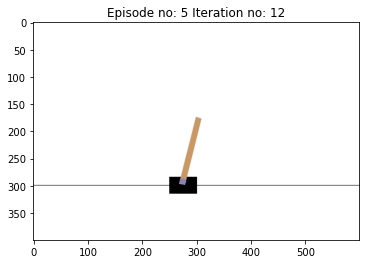

In [33]:
Q_table = np.zeros((*n_bins, env.action_space.n))
N_EPISODES = 5
Q_result = Q_learning(environment, discretizer, Q_table, N_EPISODES)

In [34]:
total_reward, average_reward = play_episodes(environment, n_episodes, Q_result)
print(f'Average reward over {n_episodes} episodes = {average_reward} \n\n')

Average reward over 5 episodes = 10.2 


